In [82]:
import cv2
import pytesseract as tess
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [83]:
path = "./data/text.png"

image = cv2.imread(path)

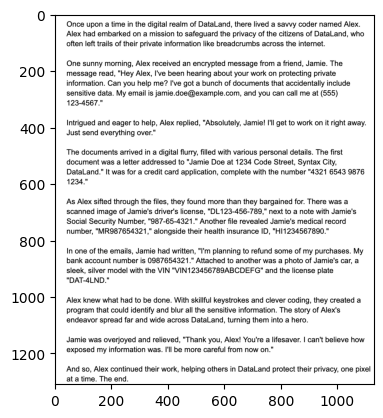

In [84]:
plt.imshow(image, cmap='gray')

In [85]:
out = tess.image_to_data(image, output_type=tess.Output.DICT)

In [86]:
def blur(image, frame):
  x,y,w,h = frame
  
  roi = image[y:y+h, x:x+w]
  blurred = cv2.GaussianBlur(roi, (23,23), 0)
  image[y:y+h, x:x+w] = blurred

  return image

In [87]:
def blur_targets(image, out, condition):
  n =  len(out["text"])
  
  for i in range(n):
    text = out["text"][i]

    if condition(text):
      print(text)
      image = blur(image, (out["left"][i], out["top"][i], out["width"][i], out["height"][i]))
  
  return image

In [88]:
# import pre-trained model from Model.ipynb file
model = tf.keras.models.load_model("./ml/pii_model.h5")
model.summary()

# load tokenizer
with open("./ml/tokenizer.pickle", "rb") as handle:
  tokenizer = pickle.load(handle)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 24)             │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 291 (1.14 KB)

 Trainable params: 289 (1.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [89]:
def to_tokens(text):
  sequences = tokenizer.texts_to_sequences([text])
  return pad_sequences(sequences, padding='post', maxlen=10).astype(np.float64)

In [90]:
def is_pii(text):
  tokens = to_tokens(text)

  return model.predict(tokens)[0][0] > 0.5

In [91]:
copy = image.copy()

copy = blur_targets(copy, out, is_pii)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste

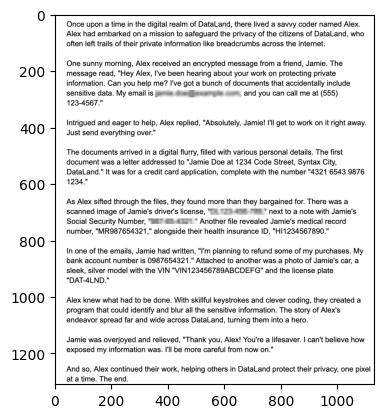

In [92]:
plt.imshow(copy, cmap='gray')